In [1]:
from validphys.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from validphys.fkparser import load_fktable
from collections import defaultdict

from typing import List, Dict
from collections import namedtuple

In [2]:
# Seed for the initialisation of the neural network
seed = 1341351341

In [3]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

In [31]:
# Flavour combination map for FK tables
flav_map = {
        0: r"$g$",
        1: r"$T_{3}$",
        2: r"$T_{{8}}$",
        3: r"$T_{15} (c^-)$",
        4: r"$\Sigma$",
        5: r"$V_3$",
        6: r"$V_8$",
        7: r"$V_{15}$",
        8: r"$V$"}

In [5]:
def generate_sequential_model(outputs=1, 
                   input_layer=None, 
                   nlayers=2, 
                   units=[100,100],
                   seed=seed,
                   **kwargs):
  """
  Create a tensorflow sequential model where all intermediate layers have the same size
  This function accepts an already constructed layer as the input.

  All hidden layers will have the same number of nodes for simplicity

  Arguments:
      outputs: int (default=1)
          number of output nodes (how many flavours are we training)
      input_layer: KerasTensor (default=None)
          if given, sets the input layer of the sequential model
      nlayers: int
          number of hidden layers of the network
      units: int
          number of nodes of every hidden layer in the network
      activation: str
          activation function to be used by the hidden layers (ex: 'tanh', 'sigmoid', 'linear')
  """
  if len(units) != nlayers:
      raise Exception("The length of units must match the number of layers.")
  
  if kwargs.get('kernel_initializer'):
      kernel_initializer = kwargs['kernel_initializer']
  else:
      kernel_initializer = tf.keras.initializers.HeNormal

  if kwargs.get('activation_list'):
      activation_list = kwargs['activation_list']
      if len(units) != len(activation_list):
          raise Exception("The length of the activation list must match the number of layers.")
  else:
      activation_list = ['tanh' for _ in range(nlayers)]

  if kwargs.get('output_func'):
      output_func = kwargs['output_func']
  else:
      output_func = 'linear'
  
  if kwargs.get('name'):
      name = kwargs['name']
  else:
      name = 'pdf'
  
  model = tf.keras.models.Sequential(name=name)
  if input_layer is not None:
      model.add(input_layer)
  for layer in range(nlayers):
      model.add(tf.keras.layers.Dense(units[layer], 
                                      activation=activation_list[layer],
                                      kernel_initializer=kernel_initializer(seed=seed - layer),
                                      ),
      )
  model.add(tf.keras.layers.Dense(outputs, 
                                  activation=output_func, 
                                  kernel_initializer=kernel_initializer(seed=seed - nlayers)
                                  ))

  return model

def compute_ntk(model, input):
  # Record operations for gradient computation
  batch_size = input.size
  n_outputs = model.layers[-1].units
  x = tf.convert_to_tensor(input)
  x = tf.reshape(x, shape=(-1,1))
  with tf.GradientTape(persistent=True) as tape:
      tape.watch(x)
      # Forward pass
      predictions = model(x)

  jacobian = tape.jacobian(predictions, model.trainable_variables)  

  ntk = tf.zeros((n_outputs, batch_size, n_outputs, batch_size))
  for jac in jacobian:
      jac_concat = tf.reshape(jac, (jac.shape[1], jac.shape[0], np.prod(jac.shape[2:]))) 
      ntk += tf.einsum('iap,jbp->iajb', jac_concat, jac_concat)  
  return ntk

In [6]:
# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'t0pdfset': '240701-02-rs-nnpdf40-baseline', 'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000
)

In [7]:
groups_data = API.procs_data(**common_dict)
groups_index = API.groups_index(**common_dict)

The cell below loops over the selected dataset and collects FK tables, $x$-grids, and central data $y$.

In [8]:
# Initialise the dictionaries
fk_table_list = defaultdict(list)
x_grid_list = defaultdict(list)
Y = defaultdict(list)

# Useful information for indexing the datasets
total_ndata_wc = 0
total_grid_size = 0
start_grid_by_exp = defaultdict(list)
grid_size_by_exp = defaultdict(list)
start_proc_by_exp = defaultdict(list)
exp_size = defaultdict(list)

for idx_proc, group_proc in enumerate(groups_data):
  for idx_exp, exp_set in enumerate(group_proc.datasets):

    fkspecs = exp_set.fkspecs
    cuts = exp_set.cuts
    ndata = exp_set.load_commondata().ndata
    fk_table = load_fktable(fkspecs[0])
    fk_table_wc = fk_table.with_cuts(cuts)
    x_grid = fk_table_wc.xgrid
    fk_table_wc_np = fk_table_wc.get_np_fktable()

    Y[exp_set.name] = exp_set.load_commondata().with_cuts(cuts).central_values.to_numpy()
    fk_table_list[exp_set.name] = fk_table_wc_np
    x_grid_list[exp_set.name] = x_grid
    start_proc_by_exp[exp_set.name] = total_ndata_wc
    start_grid_by_exp[exp_set.name] = total_grid_size
    grid_size_by_exp[exp_set.name] = x_grid.shape[0]
    total_grid_size += x_grid.shape[0]
    total_ndata_wc += ndata
    exp_size[exp_set.name] = ndata

# Flatten x-grids
x_grid_flat = np.concatenate([grid for grid in x_grid_list.values()])

Then we need to generate the model. It can be one single replica, or many replicas.

In [9]:
# Generate NNPDF model
replicas = 1

if replicas == 1:
  nnpdf = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed, name='NNPDF', kernel_initializer=tf.keras.initializers.GlorotNormal)
else:
  raise ValueError('Ensemble generation not yet implemented.')

Now we load the experimental covariance matrix and compute its inverse.

In [10]:
C = API.groups_covmat_no_table(**common_dict)
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C.index, columns=C.columns)

We then compute the NTK

In [11]:
NTK = compute_ntk(nnpdf, x_grid_flat).numpy()
NTK = NTK.reshape((NTK.shape[0] * NTK.shape[1], NTK.shape[2] * NTK.shape[3]))

Compute the matrix $M$ defined as $M = (FK)^T C^{-1}_Y (FK)$.

**Implementation details**

Each data set is provided with an FK table whose dimensions are $(N_{\textrm{dat}},\; N_f, \; N_{\textrm{grid}})$. I do the following steps
1. Flatten the last two dimensions of the FK tables, such that $(N_{\textrm{dat}},\; N_f, \; N_{\textrm{grid}}) \rightarrow (N_{\textrm{dat}},\; N_f, \times N_{\textrm{grid}})$.
2. Build the FK table of the entire dataset defined as the block diagonal matrix made of the flattened FK tables
    $$
      FK_{\mathcal{D}} = \left(\begin{matrix}
      (FK)_{I_1} && 0 && \cdots && 0 \\[5pt]
      0 && (FK)_{I_2} && \cdots && 0 \\[5pt]
      \vdots && \vdots && \ddots && \vdots \\[5pt]
      0 && 0 && \cdots && (FK)_{I_D}
      \end{matrix} \right) \,,
    $$
    where $I_i$, $i=1,\dots, D$ specifies the $i$-th dataset of the FK table.

In [12]:
from scipy.linalg import block_diag
ndat = sum([fk.shape[0] for fk in fk_table_list.values()])
FK = np.zeros(shape=(ndat, 9, x_grid_flat.size))

flatten_fks = []
exp_start_proc = defaultdict(list)
grid_fl_start_proc = defaultdict(list)
grid_fl_size_by_exp = defaultdict(list)
total_grid_fl_size = 0
total_data_size = 0
exp_ordering = []
for exp, fk in fk_table_list.items():
  fk_flatten = fk.reshape((fk.shape[0], fk.shape[1] * fk.shape[2]))
  flatten_fks.append(fk_flatten)
  exp_ordering.append(exp)
  exp_start_proc[exp] = total_data_size
  grid_fl_start_proc[exp] = total_grid_fl_size
  grid_fl_size_by_exp[exp] = fk_flatten.shape[1]
  total_data_size += fk_flatten.shape[0]
  total_grid_fl_size += fk_flatten.shape[1]

FK = block_diag(*flatten_fks)

# Check that the ordering of the block diagonal matrix is the same as the inverse covariance matrix.
for val1, val2 in zip(Cinv.index.get_level_values(level='dataset').unique().to_list(), exp_ordering):
  try:
    assert(val1 == val2)
  except:
    AssertionError("The ordering is not the same")

Now construct the matrix M

In [13]:
M = FK.T @ Cinv @ FK

Regularise the matrix through the identity and invert

In [75]:
eta_id = 0.1
Mr = M + eta_id * np.identity(M.shape[0])
Mr_inv = np.linalg.inv(Mr)

Construct the matrix that governs the evolution $H = \Theta M_R$

In [76]:
H = NTK @ Mr

Now I compute the normalisation $K = M_R^{-1} A^T C_Y^{-1} y$

In [77]:
y = []
for exp in exp_ordering:
  y.append(Y[exp])

y = np.concatenate(y)
K = Mr_inv @ FK.T @ Cinv @ y

Computing the network predictions at initialisation

In [78]:
f0 = nnpdf(x_grid_flat).numpy()
flav_grid_shape = f0.shape
f0 = f0.reshape(-1)

# Integrating the gradient flow

Constructing the integrated solution
$$
f(t) = e^{-Ht} f_0 + \left( I -  e^{-Ht} \right) K \,.
$$
We can introduce the eigenspace of the operator $H$
$$
H v^{(k)} = \lambda_k v^{(k)} \,, \hspace{5mm} k = 1, \dots, \textrm{eig}(H)\,.
$$
The vector $v^{(k)} \in \mathbb{R}^{N_{grid} \times N_f}$ is the eigenvector relative to the $k$-th eigenvalue $\lambda_k$ for the matrix $H$. We can project the integrated equation in the eigenspace of $H$
$$
\begin{split}
f^{\alpha}(t) & = \sum_{k = 1}^{\textrm{eig}(H)} \left[  e^{- t \lambda_k} \; \widetilde{f}_0^{(k)} + \left( 1 - e^{- t\lambda_k} \right) \widetilde{K}^{(k)} \right] \; v^{(k)} \\
& = \sum_{k = 1}^{\textrm{eig}(H)} \left[  C_1^{(k)} + C_2^{(k)} \right] \; v^{(k)} \,,
\end{split}
$$
where
$$
C_1^{(k)} = e^{- t \lambda_k} \; \widetilde{f}_0^{(k)} \\
C_2^{(k)} = \left( 1 - e^{- t\lambda_k} \right) \widetilde{K}^{(k)}
$$
and $\widetilde{f}_0$, $\widetilde{K}$ are the components of the respective vectors in the eigenspace of $H$
$$
\widetilde{f}_0^{(k)} = \left< f_0, v^{(k)} \right> \,,\\
\widetilde{K}^{(k)} = \left< K, v^{(k)} \right> \,.
$$

In [79]:
from functools import lru_cache

eigvals, eigvecs = np.linalg.eig(H)
eigvals = eigvals.real
eigvecs = eigvecs.real

def integrate_flow_t(t, eigvals=eigvals, eigvecs=eigvecs):

  f0_tilde = [np.dot(f0, eigvecs[:, k]) for k in range(eigvals.size)]
  K_tilde = [np.dot(K, eigvecs[:, k]) for k in range(eigvals.size)]

  output = np.zeros(shape=K.shape[0])
  for k in range(35):
      C1_k = f0_tilde[k] * np.exp(- eigvals[k] * t)
      C2_k = (1 - np.exp(- eigvals[k] * t) ) * K_tilde[k]
      output = np.add(output, (C1_k + C2_k) * eigvecs[:,k])

  return output

In [80]:
t = 10000
out = integrate_flow_t(t)
out = out.reshape(flav_grid_shape)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

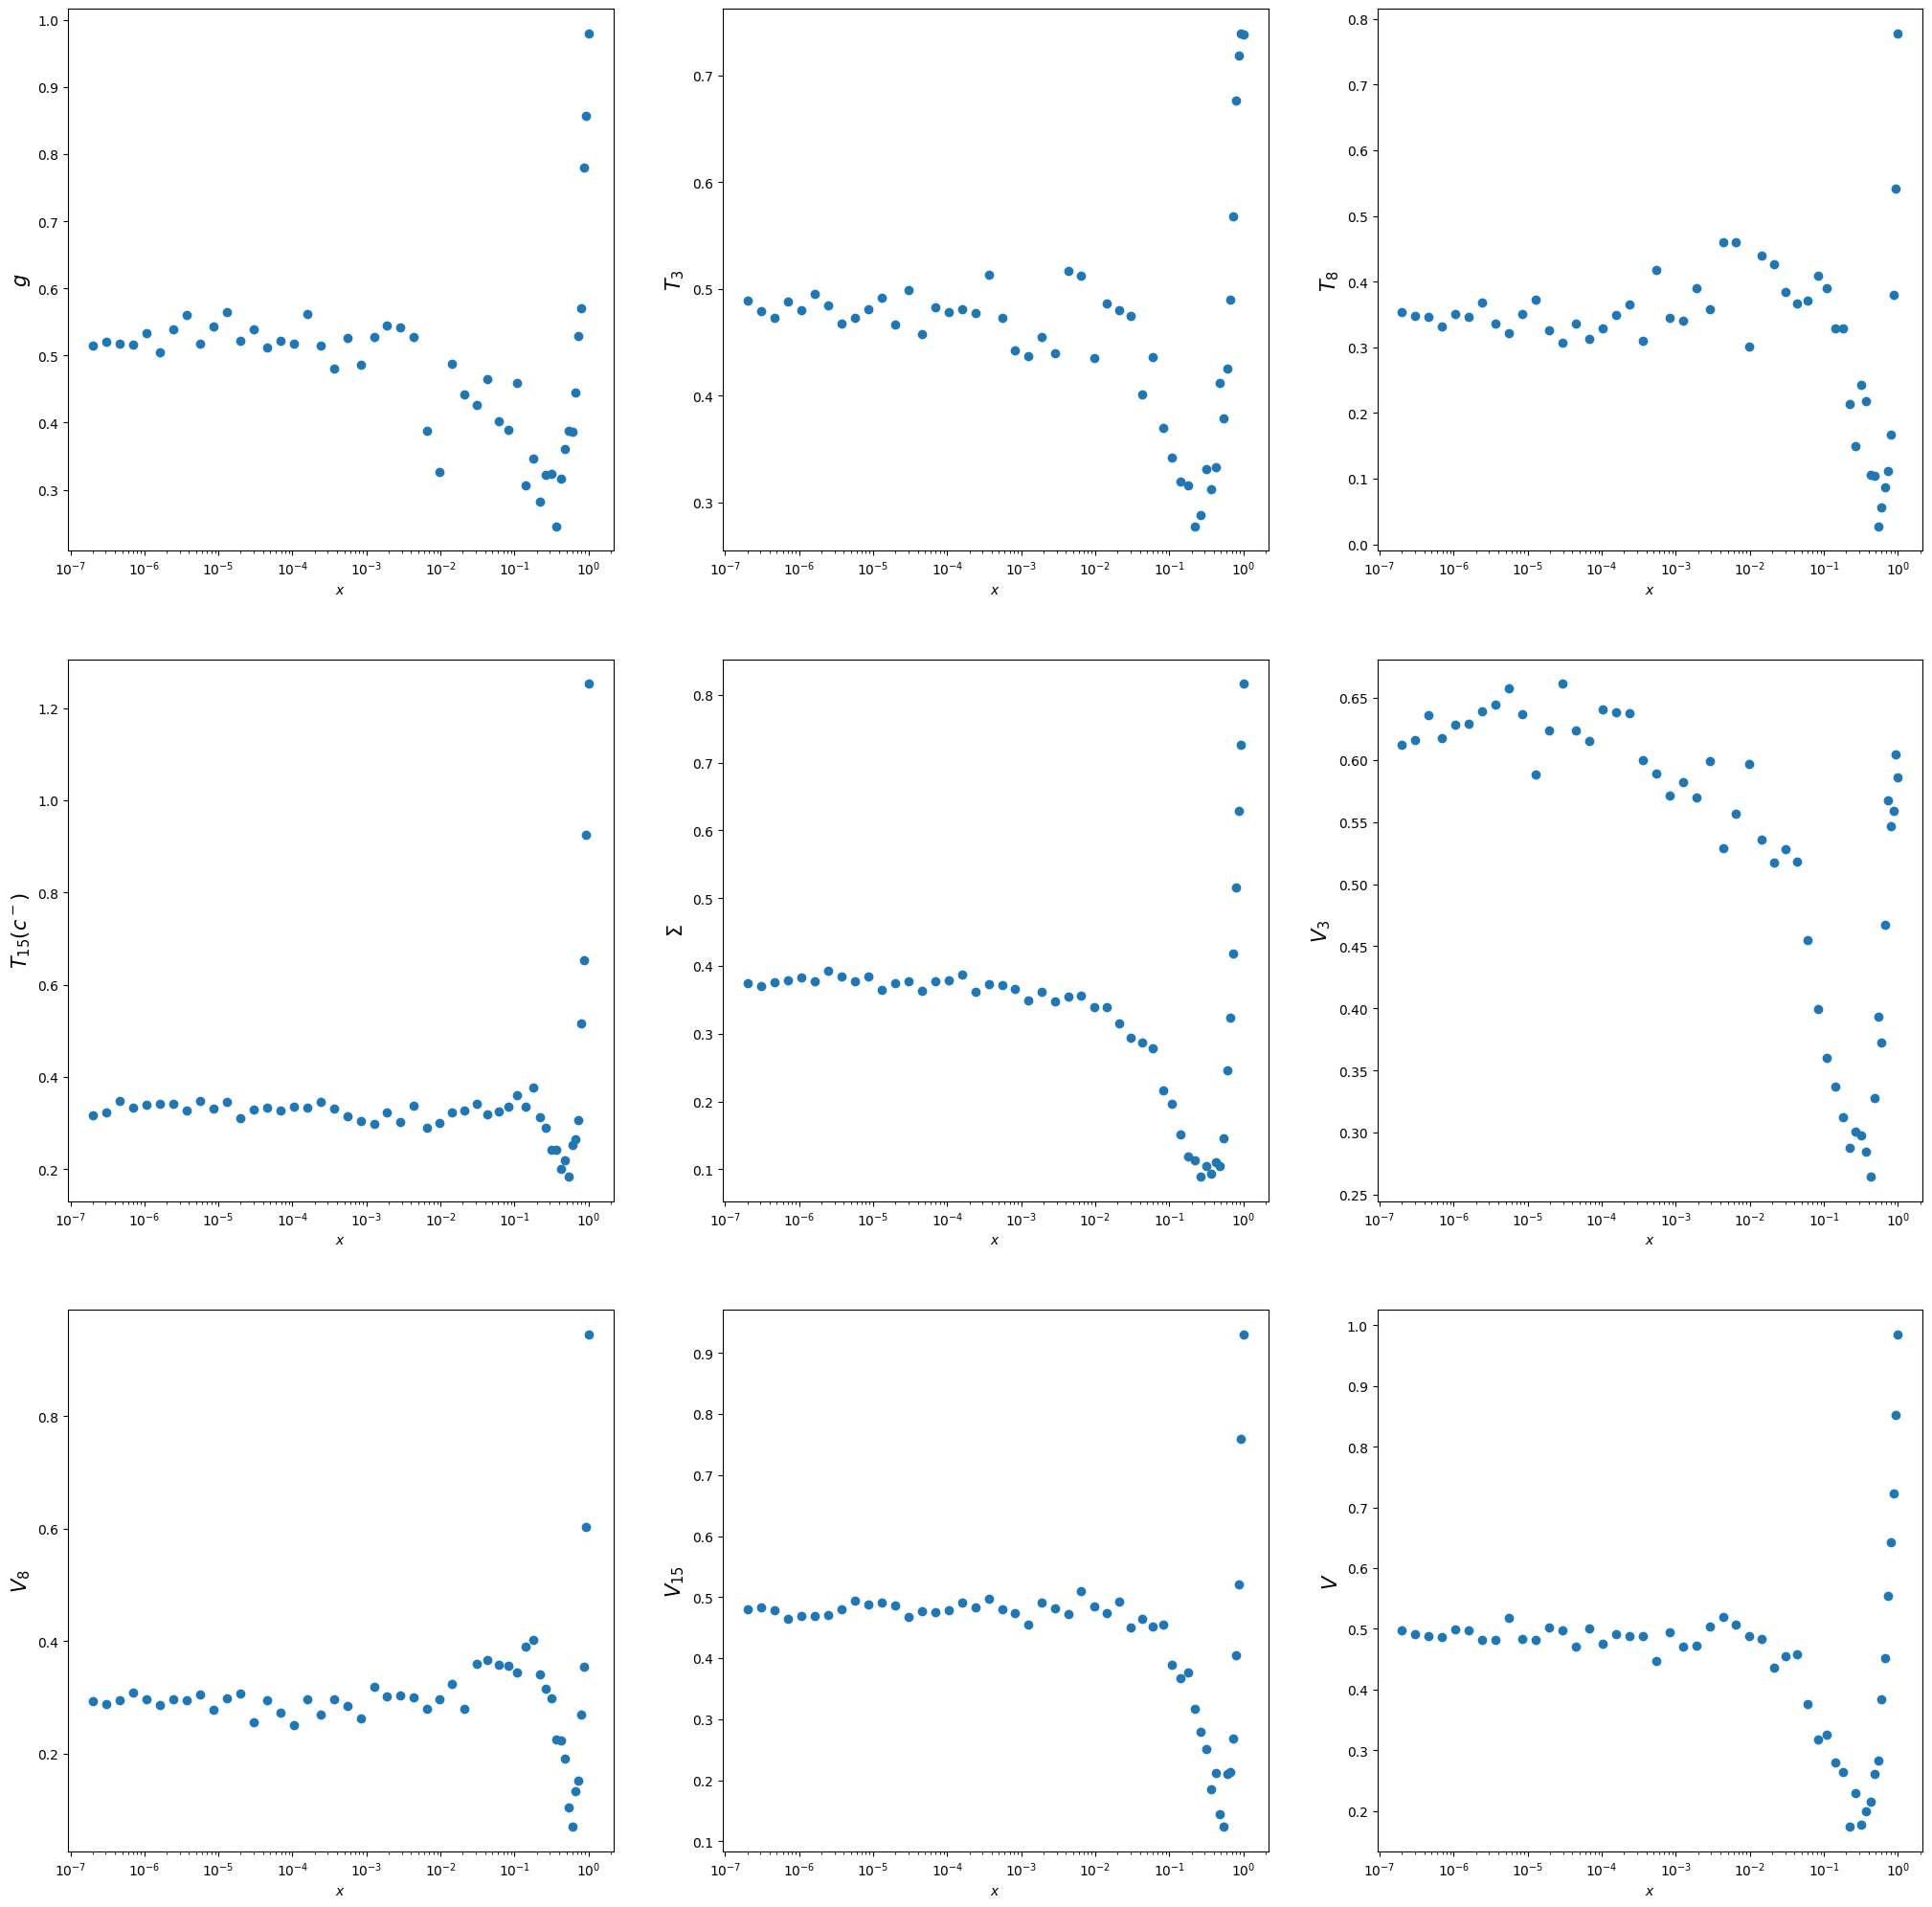

In [81]:
from scipy import interpolate as scint
fig, axes = plt.subplots(3, 3, figsize=(25, 25))  # Adjust figsize for desired plot size

xgrid_unique_values, indices = np.unique(x_grid_flat, return_index=True)
x_plot = np.logspace(-5, -4, 100)
# Example data for each subplot
for i, ax in enumerate(axes.flatten()):
    y = out[:,i][indices]
    ax.scatter(xgrid_unique_values, y)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(flav_map[i], fontsize=15)
    ax.set_xscale('log')

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout

# TODO
Do single step in step